# Fast onion peeling

Implementation of the onion peeling method, using the fast version of the trigonometric polynomial resample.

The only difference is the replacement of ``compute_alpha`` by ``fast_compute_alpha``

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ppfft.tools.pad import pad
from ppfft.tools.new_fft import new_fft2
from ppfft.resampling.fast_resampling import fast_compute_alpha
from ppfft.inverse.onion_peeling import initialize, resample_row, find_closest, onion_peeling
from ppfft.ppfft.ppfft import ppfft

In [2]:
def fast_recover_row_negative(k, vert_ppfft, Id):
    """
    Recovers row  -(n//2) < k < 0 of Id.
    Id is modified in place.
    """
    n, m = vert_ppfft.shape[0] - 1, vert_ppfft.shape[1]
    half_n = n//2
    true_k = k + half_n

    known_ppfft = vert_ppfft[:, 2 * k + n]
    y_ppfft = 8 * np.pi * k * np.arange(-half_n, half_n + 1) / (n * m)

    known_I_D_left = Id[true_k, :true_k]
    y_left = - 4 * np.pi * np.arange(-half_n, k) / m

    known_I_D_right = Id[true_k, -true_k:][::-1]
    y_right = 4 * np.pi * np.arange(-half_n, k) / m

    known_samples = np.concatenate(
        (known_I_D_left, known_ppfft, known_I_D_right))

    y = np.concatenate((y_left, y_ppfft, y_right))

    index_to_remove = find_closest(y, n)
    known_samples = np.take(known_samples, index_to_remove)
    y = np.take(y, index_to_remove)

    alpha = fast_compute_alpha(y, n, known_samples)

    res = resample_row(alpha)

    Id[true_k, true_k:-true_k] = res[true_k:-true_k]


def fast_recover_row_positive(k, vert_ppfft, Id):
    """
    Recovers row 0 < k < n//2 of Id.
    Id is modified in place.
    """
    n, m = vert_ppfft.shape[0] - 1, vert_ppfft.shape[1]
    half_n = n//2
    true_k = k + half_n

    known_ppfft = vert_ppfft[:, 2 * k + n]
    y_ppfft = 8 * np.pi * k * np.arange(-half_n, half_n + 1) / (n * m)

    known_I_D_right = Id[true_k, :(n - true_k)][::-1]
    y_left = - 4 * np.pi * np.arange(k + 1, half_n + 1) / m

    known_I_D_left = Id[true_k, (true_k - n):]
    y_right = 4 * np.pi * np.arange(k + 1, half_n + 1) / m

    known_samples = np.concatenate(
        (known_I_D_left, known_ppfft, known_I_D_right))

    y = np.concatenate(
        (y_left, y_ppfft, y_right))

    index_to_remove = find_closest(y, n)
    known_samples = np.take(known_samples, index_to_remove)
    y = np.take(y, index_to_remove)

    alpha = fast_compute_alpha(y, n, known_samples)

    res = resample_row(alpha)

    Id[true_k, (n-true_k):(true_k-n)] = res[(n-true_k):(true_k-n)]


def fast_recover_row(k, vert_ppfft, Id):
    """
    Recovers rows k and -k of Id.
    Here, -(n//2) < k < 0
   """
    n = vert_ppfft.shape[0] - 1
    assert -(n//2) < k < 0
    fast_recover_row_negative(k, vert_ppfft, Id)
    fast_recover_row_positive(-k, vert_ppfft, Id)

In [3]:
def fast_recover_col_negative(k, hori_ppfft, Id):
    """
    Recovers column -(n//2) < k < 0 of Id.
    Id is modified in place.
    """
    n, m = hori_ppfft.shape[0] - 1, hori_ppfft.shape[1]
    half_n = n//2
    true_k = k + half_n

    known_ppfft = hori_ppfft[:, 2 * k + n]  # n + 1 elements
    y_ppfft = 8 * np.pi * k * np.arange(-half_n, half_n + 1) / (n * m)

    known_I_D_left = Id[:true_k, true_k]
    y_left = - 4 * np.pi * np.arange(-half_n, k) / m

    known_I_D_right = Id[-true_k:, true_k][::-1]
    y_right = 4 * np.pi * np.arange(-half_n, k) / m

    known_samples = np.concatenate(
        (known_I_D_left, known_ppfft, known_I_D_right))

    y = np.concatenate((y_left, y_ppfft, y_right))

    index_to_remove = find_closest(y, n)
    known_samples = np.take(known_samples, index_to_remove)
    y = np.take(y, index_to_remove)

    alpha = fast_compute_alpha(y, n, known_samples)

    res = resample_row(alpha)

    Id[true_k:-true_k, true_k] = res[true_k:-true_k]


def fast_recover_col_positive(k, hori_ppfft, Id):
    """
    Recovers column 0 < k < n//2 Id.
    Id is modified in place.
    """
    n, m = hori_ppfft.shape[0] - 1, hori_ppfft.shape[1]
    half_n = n//2
    true_k = k + half_n

    known_ppfft = hori_ppfft[:, 2 * k + n]  # n + 1 elements
    y_ppfft = 8 * np.pi * k * np.arange(-half_n, half_n + 1) / (n * m)

    known_I_D_right = Id[:(n - true_k), true_k][::-1]
    y_left = - 4 * np.pi * np.arange(k + 1, half_n + 1) / m

    known_I_D_left = Id[(true_k - n):, true_k]
    y_right = 4 * np.pi * np.arange(k + 1, half_n + 1) / m

    known_samples = np.concatenate(
        (known_I_D_left, known_ppfft, known_I_D_right))

    y = np.concatenate(
        (y_left, y_ppfft, y_right))

    index_to_remove = find_closest(y, n)
    known_samples = np.take(known_samples, index_to_remove)
    y = np.take(y, index_to_remove)

    alpha = fast_compute_alpha(y, n, known_samples)

    res = resample_row(alpha)

    Id[(n - true_k):(true_k - n), true_k] = res[(n - true_k):(true_k - n)]


def fast_recover_col(k, hori_ppfft, Id):
    """
    Recovers columns k and -k of Id.
    Here, -(n//2) < k < 0
    """
    n = hori_ppfft.shape[0] - 1
    assert -(n//2) < k < 0
    fast_recover_col_negative(k, hori_ppfft, Id)
    fast_recover_col_positive(-k, hori_ppfft, Id)


In [4]:
def fast_onion_peeling(hori_ppfft, vert_ppfft):
    Id = initialize(hori_ppfft, vert_ppfft)
    n = hori_ppfft.shape[0] - 1

    for k in np.arange(-(n//2) + 1, 0):
        fast_recover_row(k, vert_ppfft, Id)
        fast_recover_col(k, hori_ppfft, Id)

    Id[n//2, n//2] = hori_ppfft[0, n]

    return Id

# Test

In [1]:
def compute_true_Id(im):
    n = len(im)
    m = 2 * n + 1
    pad_im = pad(im, (m, m))
    return new_fft2(pad_im)[::2, ::2]

In [6]:
im = plt.imread("Shepp_logan_240.png")
hori_ppfft, vert_ppfft = ppfft(im)

fast_Id = fast_onion_peeling(hori_ppfft, vert_ppfft)
slow_Id = onion_peeling(hori_ppfft, vert_ppfft)
true_Id = compute_true_Id(im)

In [7]:
print(np.sum(np.abs(fast_Id - true_Id)**2) / np.sum(np.abs(true_Id)**2))
print(np.sum(np.abs(slow_Id - true_Id)**2) / np.sum(np.abs(true_Id)**2))

3.814647729412719e-12
7.719401080501526e-16


In [8]:
print(np.max(np.abs(fast_Id - true_Id)) / np.max(np.abs(true_Id)))
print(np.max(np.abs(slow_Id - true_Id)) / np.max(np.abs(true_Id)))

4.4790404301171085e-07
2.8924621445177843e-08


[None, None, None]

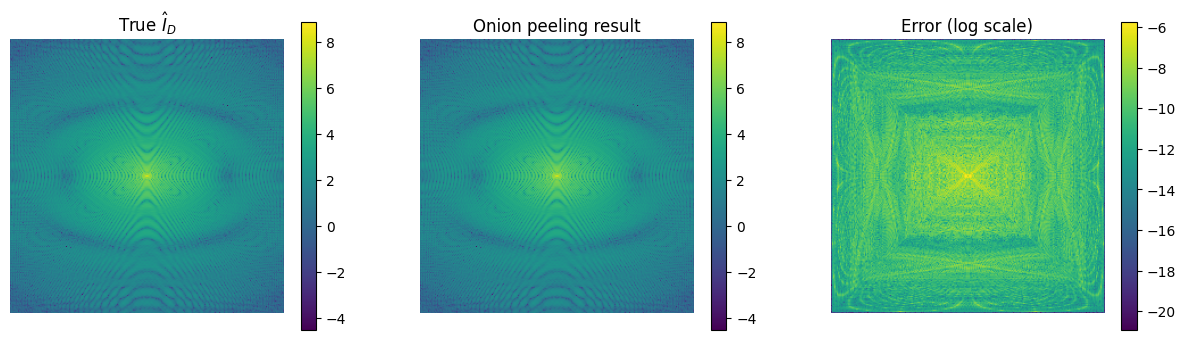

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

a = axes[0].imshow(np.log(np.abs(true_Id)))
axes[0].set_title(r"True $\hat{I}_D$")
plt.colorbar(a, ax=axes[0])

a = axes[1].imshow(np.log(np.abs(fast_Id)))
axes[1].set_title("Onion peeling result")
plt.colorbar(a, ax=axes[1])

a = axes[2].imshow(np.log(np.abs(fast_Id - true_Id)))
axes[2].set_title("Error (log scale)")
plt.colorbar(a, ax=axes[2])

[ax.set_axis_off() for ax in axes]


# Performance comparison

In [10]:
n = 300
im = np.random.rand(n, n)
hori_ppfft, vert_ppfft = ppfft(im)

In [11]:
%timeit fast_onion_peeling(hori_ppfft, vert_ppfft)

11.8 s ± 143 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%timeit onion_peeling(hori_ppfft, vert_ppfft)

22.8 s ± 1.35 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
